In [1]:
import math
import sys
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt



df = pd.read_csv('./data/training_ready_no_regression.csv')

FileNotFoundError: [Errno 2] File b'C:\\Users\\gdm17\\Desktop\\Caravana-Data-Mining-UniPi-master\\data\\training_ready_no_regression.csv' does not exist: b'C:\\Users\\gdm17\\Desktop\\Caravana-Data-Mining-UniPi-master\\data\\training_ready_no_regression.csv'

 Salviamo l'attributo "IsBadBuy" in una variabile.

In [0]:
classes = df['IsBadBuy']
del df['IsBadBuy']

Teniamo esclusivamente gli attributi numerici

In [0]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
df_numeric = df.copy(deep=True).select_dtypes(include=numerics)
del df_numeric['RefId']
del df_numeric['IsOnlineSale']
del df_numeric['VehicleAge']
df_numeric.head()

Considerando la forte correlazione presente tra i valori MMRA, decidiamo di tenere solo "MMRAcquisitionAuctionAveragePrice"

In [0]:
del df_numeric['MMRAcquisitionAuctionCleanPrice']
del df_numeric['MMRAcquisitionRetailAveragePrice']
del df_numeric['MMRAcquisitonRetailCleanPrice']
del df_numeric['MMRCurrentAuctionAveragePrice']
del df_numeric['MMRCurrentAuctionCleanPrice']
del df_numeric['MMRCurrentRetailAveragePrice']
del df_numeric['MMRCurrentRetailCleanPrice']

# Normalizzazione

Utilizziamo il metodo Min-max per effettuare la normalizzazione

In [0]:
from sklearn.preprocessing import MinMaxScaler

In [0]:
scaler = MinMaxScaler()
X = scaler.fit_transform(df_numeric.values)

# Splitting

Per problemi di memoria, suddividiamo il dataset in due più piccoli.

In [0]:
from sklearn.model_selection import train_test_split
X1,X2= train_test_split(X, test_size = 0.35)

# DBSCAN

In [0]:
from sklearn.cluster import DBSCAN
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import silhouette_score

Calcoliamo la distanza euclidea tra tutti i punti del dataset

In [0]:
dist = pdist(X1, 'euclidean')
dist = squareform(dist)

Per ogni punto prendiamo la distanza con il suo 10 punto più lontano. Mettiamo le distanze ottenute in ordine di grandenza e sviluppiamo il grafico.

In [0]:
k = 30
kth_distances = list()
for d in dist:
    index_kth_distance = np.argsort(d)[k]
    kth_distances.append(d[index_kth_distance])

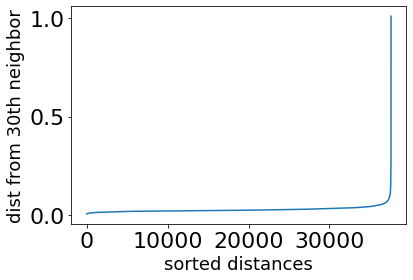

In [11]:
plt.plot(range(0, len(kth_distances)), sorted(kth_distances))
plt.ylabel('dist from %sth neighbor' % k, fontsize=18)
plt.xlabel('sorted distances', fontsize=18)
plt.ylim(0, 0.02)
plt.tick_params(axis='both', which='major', labelsize=22)
plt.show()

Selezionati K e eps, applichiamo l'algoritmo su tutto il dataset.

In [12]:
dbscan = DBSCAN(eps=0.15, min_samples=30)
dbscan.fit(X)

DBSCAN(algorithm='auto', eps=0.15, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=30, n_jobs=None, p=None)

# Validation

In [13]:

print('Silhouette %s' % silhouette_score(X, dbscan.labels_))

Silhouette 0.6768977723907297


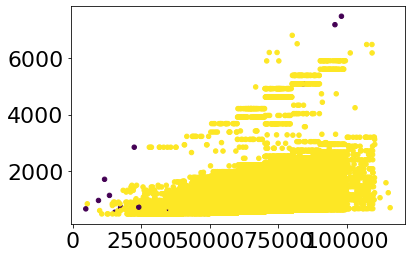

In [14]:
plt.scatter(df['VehOdo'], df['WarrantyCost'], c=dbscan.labels_, s=20)
plt.tick_params(axis='both', which='major', labelsize=22)
plt.show()

# Outliers

Osserviamo i risultati ottenuti da DBSCAN. I valori etichettati con -1 sono noise, quelli con 0 appartengono al Cluster ottenuto.

In [15]:
np.unique(dbscan.labels_, return_counts=True)

(array([-1,  0], dtype=int64), array([   19, 57844], dtype=int64))

In [16]:
outliers_df = df[dbscan.labels_ == -1]
outliers_df.head()

,RefId,PurchDate,Auction,VehicleAge,Make,Model,Trim,SubModel,Color,Transmission,...,MMRAcquisitonRetailCleanPrice,MMRCurrentAuctionAveragePrice,MMRCurrentAuctionCleanPrice,MMRCurrentRetailAveragePrice,MMRCurrentRetailCleanPrice,VNST,VehBCost,IsOnlineSale,WarrantyCost,ModelSimple
5035,39780,5/24/2010,MANHEIM,3,TOYOTA,TUNDRA PICKUP 2WD V8,SR5,DOUBLE CAB 4.7L SR5,MAROON,AUTO,...,23011.0,16988.0,18762.0,21431.0,23285.0,AZ,10402.89,0,522,TUNDRA PICKUP
5852,38052,11/20/2009,MANHEIM,3,INFINITI,M35,BAS,4D SEDAN,OTHER,AUTO,...,23833.0,15605.0,17621.0,20090.0,22120.0,NV,10738.65,0,762,M35
6681,37073,6/16/2010,MANHEIM,3,INFINITI,M35,BAS,4D SEDAN,GREY,AUTO,...,29981.0,21940.0,24293.0,27269.0,30194.0,TX,20100.00,0,1020,M35
7324,53100,9/14/2010,OTHER,3,INFINITI,G35,BAS,4D SEDAN,SILVER,AUTO,...,25640.0,17844.0,19760.0,22417.0,24653.0,AZ,19000.00,0,764,G35
12457,22292,9/30/2009,MANHEIM,1,TOYOTA,HIGHLANDER 4WD V6,LIM,4D SPORT UTILITY HYBRID LIMITED,BLACK,AUTO,...,40308.0,35722.0,36859.0,39080.0,40308.0,CA,35900.00,0,702,HIGHLANDER


# - DISTANZA "COSINE"

Calcoliamo la distanza 'cosine' tra tutti i punti del dataset

In [9]:
dist = pdist(X1, 'cosine')
dist = squareform(dist)

In [10]:
k = 30
kth_distances = list()
for d in dist:
    index_kth_distance = np.argsort(d)[k]
    kth_distances.append(d[index_kth_distance])

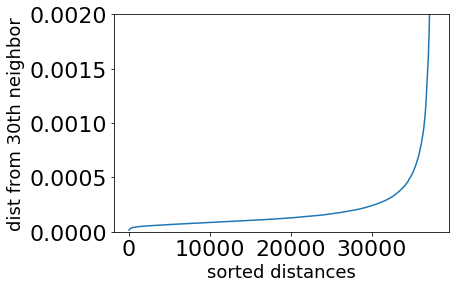

In [11]:
plt.plot(range(0, len(kth_distances)), sorted(kth_distances))
plt.ylabel('dist from %sth neighbor' % k, fontsize=18)
plt.ylim((0,0.002))
plt.xlabel('sorted distances', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=22)
plt.show()

Applichiamo l'algoritmo.

In [12]:
dbscan = DBSCAN(eps=0.003, min_samples=50, metric='cosine')
dbscan.fit(X)

DBSCAN(algorithm='auto', eps=0.003, leaf_size=30, metric='cosine',
       metric_params=None, min_samples=50, n_jobs=None, p=None)

Validazione

In [13]:
np.unique(dbscan.labels_, return_counts=True)

(array([-1,  0,  1], dtype=int64), array([  207, 57208,   448], dtype=int64))

In [14]:
print('Silhouette %s' % silhouette_score(X, dbscan.labels_))

Silhouette 0.4848213656187927


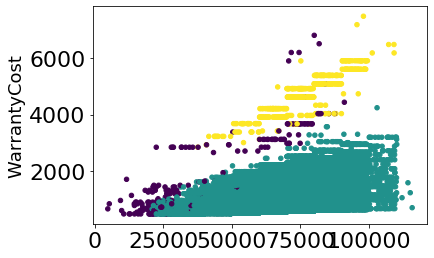

In [60]:
plt.scatter(df['VehOdo'], df['WarrantyCost'], c=dbscan.labels_, s=20)
plt.tick_params(axis='both', which='major', labelsize=22)
plt.ylabel('WarrantyCost', fontsize=18)
plt.show()

L'algoritmo ha suddiviso il set in due cluster. Il primo, c0, conta 57208 elementi ovvero il 99% del dataset. Il secondo, c1, 448. 207 Record sono invece stati classificati come "noise". Studiamo la composizione del cluster c1.

In [ ]:
models = {}
eps = np.arange(0.0001, 0.0006, 0.0001)
min_pts =np.arange(10, 100, 10)
for e in eps:
    for mins in min_pts:
        dbscan = DBSCAN(eps=e, min_samples=mins, metric='cosine')
        models[str(e)+'_'+str(mins)]=dbscan.fit(X)

for m in models.values():
    plt.scatter(df_numeric['VehOdo'], df_numeric['WarrantyCost'], c=m.labels_, s=20)
    plt.tick_params(axis='both', which='major', labelsize=22)
    plt.show()

for m in models.values():
    plt.scatter(df_numeric['VehOdo'], df_numeric['VehBCost'], c=m.labels_, s=20)
    plt.tick_params(axis='both', which='major', labelsize=22)
    plt.show()


In [15]:
c1_df = df[dbscan.labels_ == 1]
c1_df.head()

,RefId,PurchDate,Auction,VehicleAge,Make,Model,Trim,SubModel,Color,Transmission,...,MMRAcquisitonRetailCleanPrice,MMRCurrentAuctionAveragePrice,MMRCurrentAuctionCleanPrice,MMRCurrentRetailAveragePrice,MMRCurrentRetailCleanPrice,VNST,VehBCost,IsOnlineSale,WarrantyCost,ModelSimple
228,11309,3/15/2010,MANHEIM,5,CHEVROLET,VENTURE FWD V6,LS,PASSENGER EXT 3.4L LS,MAROON,AUTO,...,9924.0,4250.0,5566.0,8008.0,9811.0,NC,6100.0,0,5092,VENTURE
591,47981,11/17/2010,MANHEIM,5,BUICK,RENDEZVOUS FWD,CX,4D SUV CX,SILVER,AUTO,...,11162.0,4933.0,5783.0,9202.0,9665.0,FL,6650.0,0,4032,RENDEZVOUS
637,15067,7/29/2009,MANHEIM,6,CHEVROLET,VENTURE FWD V6 3.4L,BAS,PASSENGER EXT 3.4L LS,BEIGE,AUTO,...,4598.0,2690.0,3756.0,3405.0,4556.0,CA,3380.0,0,5392,VENTURE
759,56686,6/4/2009,OTHER,5,CHEVROLET,VENTURE FWD V6 3.4L,LS,PASSENGER 3.4L,GREEN,AUTO,...,5941.0,3504.0,5047.0,4284.0,5951.0,MS,4700.0,0,4622,VENTURE
766,61803,10/16/2009,ADESA,4,PONTIAC,MONTANA FWD 3.5L V6,SV6,4D MINIVAN EXT 3.4L,SILVER,AUTO,...,7776.0,4082.0,5446.0,8424.0,9670.0,CA,5950.0,0,3910,MONTANA


Osserviamo che tutte hanno il cambio automatico. Il dato non sembra rilevante, dato che la maggioranza di record nel dataset aveva il cambio automatico.

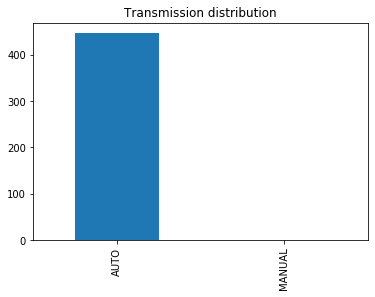

In [19]:
#Hanno tutte il cambio automatico

c1_df['Transmission'].value_counts().plot(kind='bar', title='Transmission distribution')
plt.show()

Il primo grafico mostra come il cluster c1 contenga solo macchine americane. Il secondo grafico mostra la distribuzione della nazionalità in tutto il dataset. Anche questo dato sembra poco rilevante.

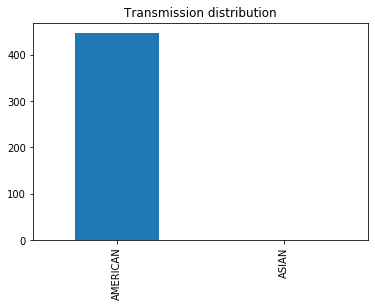

In [27]:
#Sono tutte auto americane

c1_df['Nationality'].value_counts().plot(kind='bar', title='Transmission distribution')
plt.show()

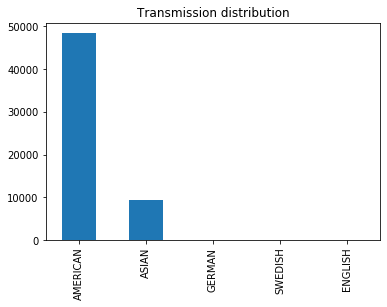

In [15]:
df['Nationality'].value_counts().plot(kind='bar', title='Transmission distribution')
plt.show()

Non sembra invece casuale, dato il grande numero di variabili possibili, il fatto gli item di questo cluster abbiano come produttori principali "chevrolet" e "pontiac".

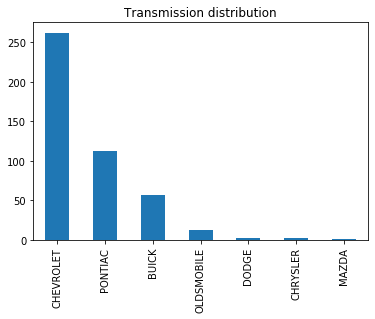

In [29]:
c1_df['Make'].value_counts().plot(kind='bar', title='Transmission distribution')
plt.show()

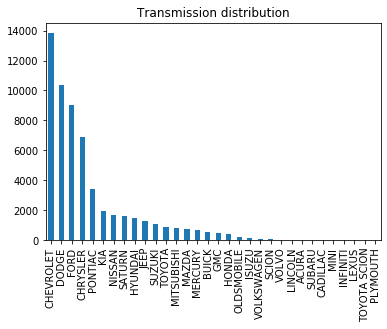

In [18]:
df['Make'].value_counts().plot(kind='bar', title='Transmission distribution')
plt.show()

Anche i modelli delle automobili raffigurano una certa regolarità. Tutte i 141 modelli "Venture FWD V6" appartengono al cluster, così come tutte le 129 "Venture FWD V6 3.4L". Delle 65 "Rendezvous FWD" ne fanno parte circa 30, ecc.ecc.

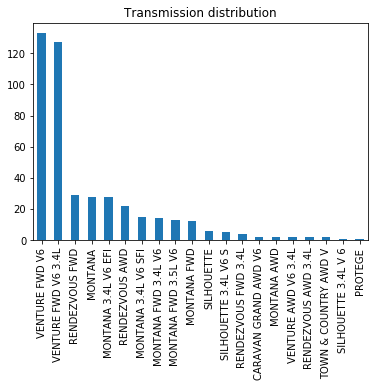

In [20]:
#Hanno molti meno modelli rispetto al dataset

c1_df['Model'].value_counts().plot(kind='bar', title='Transmission distribution')
plt.show()

In [23]:
#Non trovavo un altro modo per contare. Nel dataset sono 141, più o meno tutte quelle che sono nel cluster.
df[df['Model']=='VENTURE FWD V6']

,RefId,PurchDate,Auction,VehicleAge,Make,Model,Trim,SubModel,Color,Transmission,...,MMRAcquisitonRetailCleanPrice,MMRCurrentAuctionAveragePrice,MMRCurrentAuctionCleanPrice,MMRCurrentRetailAveragePrice,MMRCurrentRetailCleanPrice,VNST,VehBCost,IsOnlineSale,WarrantyCost,ModelSimple
228,11309,3/15/2010,MANHEIM,5,CHEVROLET,VENTURE FWD V6,LS,PASSENGER EXT 3.4L LS,MAROON,AUTO,...,9924.00000,4250.0,5566.0,8008.0,9811.0,NC,6100.0,0,5092,VENTURE
953,21362,7/23/2010,OTHER,8,CHEVROLET,VENTURE FWD V6,LS,PASSENGER 3.4L VALUE,WHITE,AUTO,...,7146.00000,2943.0,4579.0,6114.0,8106.0,CA,4700.0,0,2836,VENTURE
1022,43319,6/23/2010,MANHEIM,6,CHEVROLET,VENTURE FWD V6,LS,PASSENGER 3.4L,BLUE,AUTO,...,9819.00000,4700.0,5802.0,8481.0,9878.0,FL,5200.0,0,4622,VENTURE
1268,33219,10/29/2010,OTHER,8,CHEVROLET,VENTURE FWD V6,LS,PASSENGER 3.4L,SILVER,AUTO,...,6483.00000,2711.0,3649.0,5505.0,6411.0,FL,4325.0,0,4922,VENTURE
1622,54928,7/9/2010,OTHER,8,CHEVROLET,VENTURE FWD V6,LS,PASSENGER 3.4L,SILVER,AUTO,...,8779.00000,1954.0,3190.0,4622.0,5906.0,OK,5900.0,0,3222,VENTURE
1772,54570,6/25/2010,OTHER,7,CHEVROLET,VENTURE FWD V6,LS,PASSENGER 3.4L,BLUE,AUTO,...,10795.00000,5062.0,6102.0,8377.0,9263.0,CA,6100.0,0,3676,VENTURE
2049,41133,1/28/2010,MANHEIM,8,CHEVROLET,VENTURE FWD V6,LS,PASSENGER EXT 3.4L,GREEN,AUTO,...,6034.00000,3124.0,4304.0,5965.0,7318.0,SC,5455.0,0,4922,VENTURE
2580,32267,8/10/2010,OTHER,6,CHEVROLET,VENTURE FWD V6,LS,PASSENGER 3.4L,BLUE,AUTO,...,9032.00000,2258.0,3349.0,5793.0,7013.0,TN,5600.0,0,4622,VENTURE
3548,5818,7/12/2010,MANHEIM,7,CHEVROLET,VENTURE FWD V6,LS,PASSENGER 3.4L,WHITE,AUTO,...,11061.00000,5126.0,5950.0,9452.0,10478.0,AZ,4400.0,0,3676,VENTURE
4237,48324,11/30/2010,OTHER,6,CHEVROLET,VENTURE FWD V6,LS,PASSENGER EXT 3.4L,MAROON,AUTO,...,7528.00000,2484.0,3098.0,6046.0,6732.0,LA,5525.0,0,4622,VENTURE


Vediamo che la maggior parte di queste auto sono di grandi dimensioni: in particolare sono van, furgoncini in pratica, e Suv di media dimensione. (Quindi sono escluse auto di lusso - compresi veri e propri suv - e utilitarie. Forse sono auto più adatte per lavoro / trasporto di merci?)

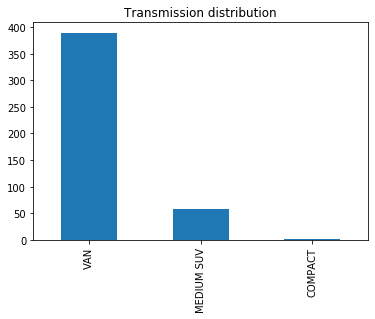

In [41]:
#Hanno molti meno Size rispetto al dataset

c1_df['Size'].value_counts().plot(kind='bar', title='Transmission distribution')
plt.show()

Il prezzo medio di acquisto di queste auto è leggermente inferiore.

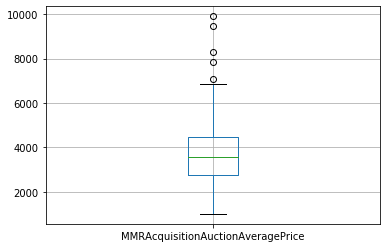

In [44]:
boxplot = c1_df.boxplot(column=['MMRAcquisitionAuctionAveragePrice'])

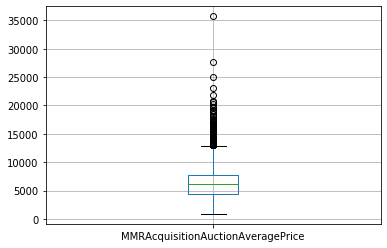

In [46]:
boxplot = df.boxplot(column=['MMRAcquisitionAuctionAveragePrice'])

Ma il costo medio della garanzia è MOLTO più alto.

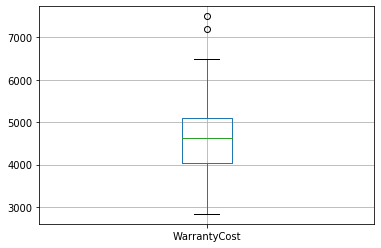

In [50]:
boxplot = c1_df.boxplot(column=['WarrantyCost'])

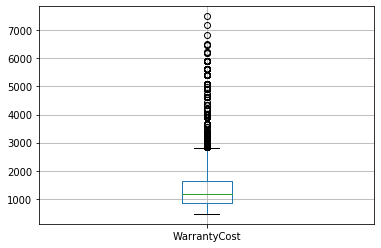

In [51]:
boxplot = df.boxplot(column=['WarrantyCost'])

L'odometro è nella media.

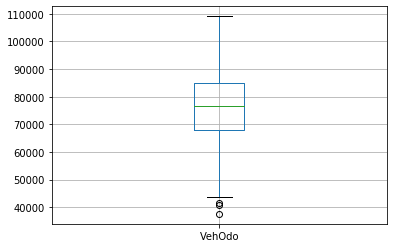

In [58]:
boxplot = c1_df.boxplot(column=['VehOdo'])

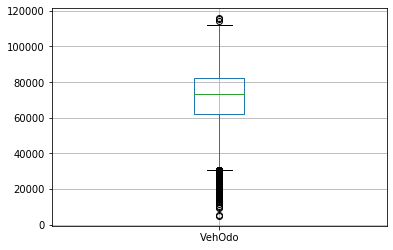

In [59]:
boxplot = df.boxplot(column=['VehOdo'])

Possiamo quindi dedurre che il cluster raffigura un gruppo di macchine ben preciso: Van americani con basso prezzo d'acquisto ma alto costo di garanzia.